
# Overwatch Hero Psychology: Archetypes, Similarity, and Player Identity

This notebook extends the original **"We Are Who We Lock"** analysis to the full 45-hero Overwatch roster.

We will:
- Build a custom hero dataset with **Mobility**, **Self-Sustain**, **Mechanical Skill**, and **HP**.
- Use **cosine similarity** to see which heroes "think" alike.
- Use **PCA** to create a 2D **hero psychology space**.
- Use **K-Means clustering** to discover four hero **archetypes**.
- Visualize archetypes with **radar charts** and **parallel coordinates**.
- Export:
  - `overwatch_full_similarity_top5.csv` — Top-5 matches for each hero.
  - `overwatch_hero_archetypes.csv` — Hero →Role→Archetype mapping.


## 1. Imports & Global Styling

In [129]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Plot styling
plt.rcParams["figure.figsize"] = (10, 7)
sns.set_style("whitegrid")

role_colors = {"Tank": "#1f77b4", "Damage": "#d62728", "Support": "#2ca02c"}


## 2. Build Full 45-Hero Dataset

In [130]:

# Define final columns
columns = [
    "Hero", "Mobility", "Self_Sustain", "Mechanical_Skill",
    "HP", "Damage", "Support", "Tank"
]

# Full Roster: 45 Heroes (Updated for Season 20 / Nov 2025)
heroes_data = [
    # --- TANK HEROES ---
    {"Hero": "D.Va", "Mobility": 8, "Self_Sustain": 6, "Mechanical_Skill": 5, "HP": 725, "Role": "Tank"},
    {"Hero": "Doomfist", "Mobility": 10, "Self_Sustain": 7, "Mechanical_Skill": 10, "HP": 525, "Role": "Tank"},
    {"Hero": "Hazard", "Mobility": 7, "Self_Sustain": 8, "Mechanical_Skill": 6, "HP": 650, "Role": "Tank"},
    {"Hero": "Junker Queen", "Mobility": 6, "Self_Sustain": 8, "Mechanical_Skill": 7, "HP": 525, "Role": "Tank"},
    {"Hero": "Mauga", "Mobility": 4, "Self_Sustain": 9, "Mechanical_Skill": 5, "HP": 725, "Role": "Tank"},
    {"Hero": "Orisa", "Mobility": 3, "Self_Sustain": 9, "Mechanical_Skill": 4, "HP": 625, "Role": "Tank"},
    {"Hero": "Ramattra", "Mobility": 4, "Self_Sustain": 7, "Mechanical_Skill": 6, "HP": 600, "Role": "Tank"},
    {"Hero": "Reinhardt", "Mobility": 3, "Self_Sustain": 6, "Mechanical_Skill": 4, "HP": 700, "Role": "Tank"},
    {"Hero": "Roadhog", "Mobility": 2, "Self_Sustain": 10, "Mechanical_Skill": 5, "HP": 750, "Role": "Tank"},
    {"Hero": "Sigma", "Mobility": 2, "Self_Sustain": 7, "Mechanical_Skill": 8, "HP": 625, "Role": "Tank"},
    {"Hero": "Winston", "Mobility": 8, "Self_Sustain": 5, "Mechanical_Skill": 6, "HP": 625, "Role": "Tank"},
    {"Hero": "Wrecking Ball", "Mobility": 10, "Self_Sustain": 8, "Mechanical_Skill": 10, "HP": 775, "Role": "Tank"},
    {"Hero": "Zarya", "Mobility": 2, "Self_Sustain": 6, "Mechanical_Skill": 7, "HP": 550, "Role": "Tank"},

    # --- DAMAGE HEROES ---
    {"Hero": "Ashe", "Mobility": 5, "Self_Sustain": 2, "Mechanical_Skill": 9, "HP": 250, "Role": "Damage"},
    {"Hero": "Bastion", "Mobility": 2, "Self_Sustain": 4, "Mechanical_Skill": 4, "HP": 300, "Role": "Damage"},
    {"Hero": "Cassidy", "Mobility": 3, "Self_Sustain": 3, "Mechanical_Skill": 9, "HP": 275, "Role": "Damage"},
    {"Hero": "Echo", "Mobility": 9, "Self_Sustain": 4, "Mechanical_Skill": 9, "HP": 250, "Role": "Damage"},
    {"Hero": "Freja", "Mobility": 6, "Self_Sustain": 3, "Mechanical_Skill": 8, "HP": 250, "Role": "Damage"},
    {"Hero": "Genji", "Mobility": 9, "Self_Sustain": 3, "Mechanical_Skill": 10, "HP": 250, "Role": "Damage"},
    {"Hero": "Hanzo", "Mobility": 5, "Self_Sustain": 2, "Mechanical_Skill": 9, "HP": 250, "Role": "Damage"},
    {"Hero": "Junkrat", "Mobility": 7, "Self_Sustain": 2, "Mechanical_Skill": 5, "HP": 250, "Role": "Damage"},
    {"Hero": "Mei", "Mobility": 2, "Self_Sustain": 9, "Mechanical_Skill": 5, "HP": 300, "Role": "Damage"},
    {"Hero": "Pharah", "Mobility": 9, "Self_Sustain": 2, "Mechanical_Skill": 7, "HP": 250, "Role": "Damage"},
    {"Hero": "Reaper", "Mobility": 7, "Self_Sustain": 8, "Mechanical_Skill": 4, "HP": 300, "Role": "Damage"},
    {"Hero": "Sojourn", "Mobility": 8, "Self_Sustain": 2, "Mechanical_Skill": 9, "HP": 250, "Role": "Damage"},
    {"Hero": "Soldier: 76", "Mobility": 6, "Self_Sustain": 7, "Mechanical_Skill": 6, "HP": 250, "Role": "Damage"},
    {"Hero": "Sombra", "Mobility": 9, "Self_Sustain": 6, "Mechanical_Skill": 7, "HP": 250, "Role": "Damage"},
    {"Hero": "Symmetra", "Mobility": 4, "Self_Sustain": 5, "Mechanical_Skill": 6, "HP": 250, "Role": "Damage"},
    {"Hero": "Torbjörn", "Mobility": 3, "Self_Sustain": 6, "Mechanical_Skill": 5, "HP": 300, "Role": "Damage"},
    {"Hero": "Tracer", "Mobility": 10, "Self_Sustain": 4, "Mechanical_Skill": 9, "HP": 175, "Role": "Damage"},
    {"Hero": "Vendetta", "Mobility": 6, "Self_Sustain": 6, "Mechanical_Skill": 8, "HP": 250, "Role": "Damage"},
    {"Hero": "Venture", "Mobility": 8, "Self_Sustain": 6, "Mechanical_Skill": 6, "HP": 250, "Role": "Damage"},
    {"Hero": "Widowmaker", "Mobility": 4, "Self_Sustain": 1, "Mechanical_Skill": 10, "HP": 200, "Role": "Damage"},

    # --- SUPPORT HEROES ---
    {"Hero": "Ana", "Mobility": 1, "Self_Sustain": 5, "Mechanical_Skill": 9, "HP": 250, "Role": "Support"},
    {"Hero": "Baptiste", "Mobility": 6, "Self_Sustain": 7, "Mechanical_Skill": 8, "HP": 250, "Role": "Support"},
    {"Hero": "Brigitte", "Mobility": 4, "Self_Sustain": 7, "Mechanical_Skill": 4, "HP": 250, "Role": "Support"},
    {"Hero": "Illari", "Mobility": 5, "Self_Sustain": 6, "Mechanical_Skill": 8, "HP": 250, "Role": "Support"},
    {"Hero": "Juno", "Mobility": 8, "Self_Sustain": 3, "Mechanical_Skill": 6, "HP": 250, "Role": "Support"},
    {"Hero": "Kiriko", "Mobility": 8, "Self_Sustain": 7, "Mechanical_Skill": 8, "HP": 250, "Role": "Support"},
    {"Hero": "Lifeweaver", "Mobility": 6, "Self_Sustain": 6, "Mechanical_Skill": 4, "HP": 275, "Role": "Support"},
    {"Hero": "Lúcio", "Mobility": 9, "Self_Sustain": 6, "Mechanical_Skill": 8, "HP": 250, "Role": "Support"},
    {"Hero": "Mercy", "Mobility": 8, "Self_Sustain": 6, "Mechanical_Skill": 3, "HP": 250, "Role": "Support"},
    {"Hero": "Moira", "Mobility": 7, "Self_Sustain": 9, "Mechanical_Skill": 3, "HP": 250, "Role": "Support"},
    {"Hero": "Wuyang", "Mobility": 5, "Self_Sustain": 6, "Mechanical_Skill": 7, "HP": 250, "Role": "Support"},
    {"Hero": "Zenyatta", "Mobility": 1, "Self_Sustain": 4, "Mechanical_Skill": 9, "HP": 250, "Role": "Support"},
]

df = pd.DataFrame(heroes_data)

# One-hot encode roles
df["Damage"] = df["Role"].apply(lambda x: 1 if x == "Damage" else 0)
df["Support"] = df["Role"].apply(lambda x: 1 if x == "Support" else 0)
df["Tank"] = df["Role"].apply(lambda x: 1 if x == "Tank" else 0)

df = df[["Hero", "Mobility", "Self_Sustain", "Mechanical_Skill", "HP", "Damage", "Support", "Tank", "Role"]]

print(f"Dataset has {len(df)} heroes.")
df.head()


Dataset has 45 heroes.


,Hero,Mobility,Self_Sustain,Mechanical_Skill,HP,Damage,Support,Tank,Role
0,D.Va,8,6,5,725,0,0,1,Tank
1,Doomfist,10,7,10,525,0,0,1,Tank
2,Hazard,7,8,6,650,0,0,1,Tank
3,Junker Queen,6,8,7,525,0,0,1,Tank
4,Mauga,4,9,5,725,0,0,1,Tank


## 3. Feature Selection & Scaling

In [131]:

features = ["Mobility", "Self_Sustain", "Mechanical_Skill", "HP"]

X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=features)
df_scaled["Hero"] = df["Hero"]
df_scaled["Role"] = df["Role"]

df_scaled.head()


,Mobility,Self_Sustain,Mechanical_Skill,HP,Hero,Role
0,0.851964,0.167620,-0.865687,1.942846,D.Va,Tank
1,1.611140,0.611320,1.569058,0.856783,Doomfist,Tank
2,0.472376,1.055020,-0.378738,1.535572,Hazard,Tank
3,0.092788,1.055020,0.108211,0.856783,Junker Queen,Tank
4,-0.666388,1.498719,-0.865687,1.942846,Mauga,Tank


### 3.1 Raw Feature Distributions by Role

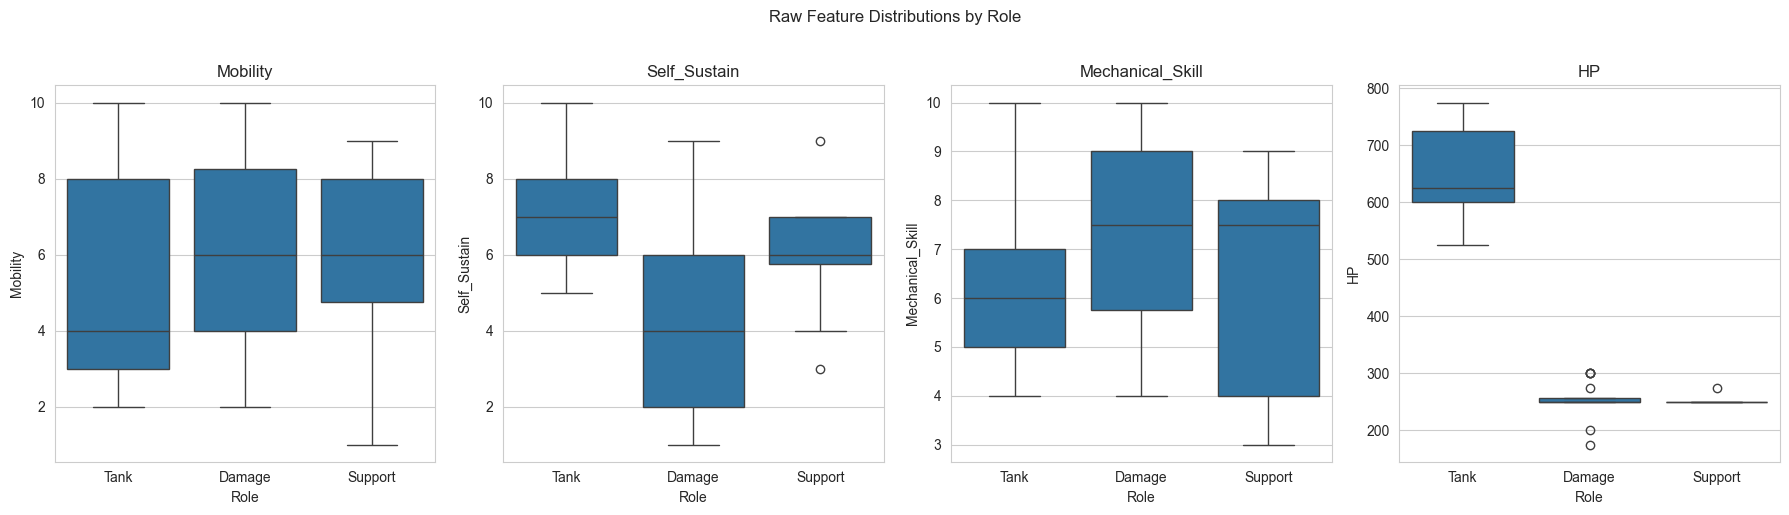

In [132]:

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for i, feat in enumerate(features):
    sns.boxplot(data=df, x="Role", y=feat, ax=axes[i])
    axes[i].set_title(feat)

fig.suptitle("Raw Feature Distributions by Role", y=1.02)
plt.tight_layout()
plt.show()


### 3.2 Standardized Feature Distributions by Role

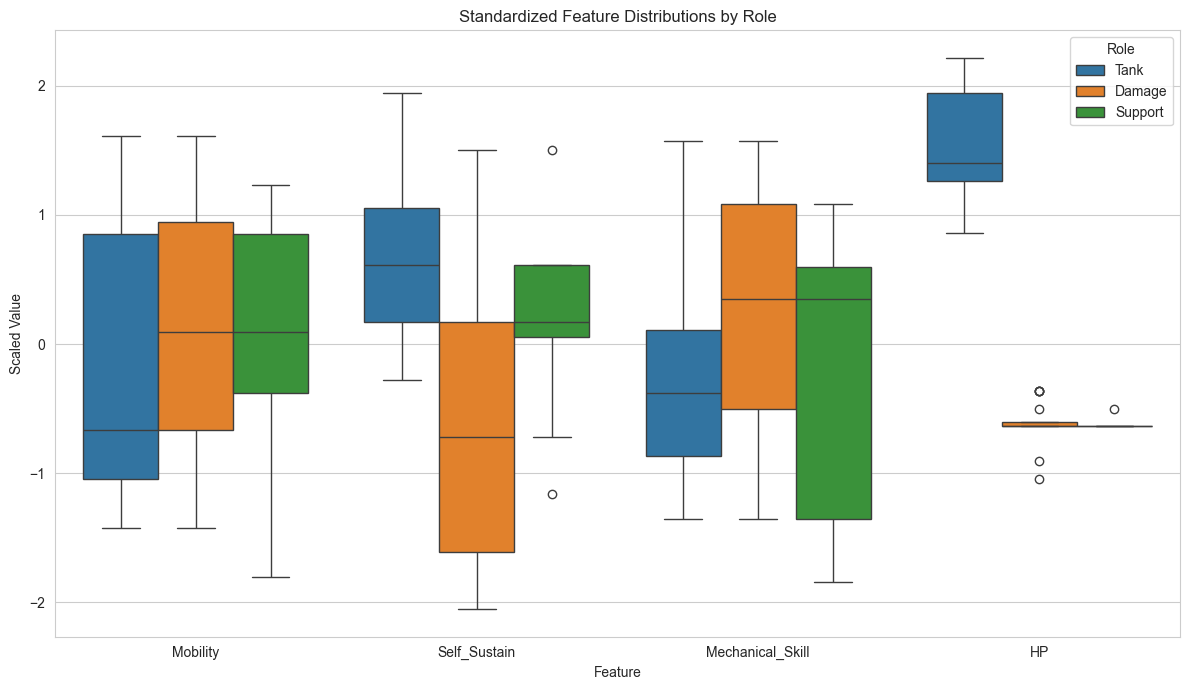

In [133]:

scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=features)
scaled_df["Role"] = df["Role"]

melted_scaled = scaled_df.melt(id_vars=["Role"], 
                               value_vars=features, 
                               var_name="Feature", 
                               value_name="Scaled Value")

plt.figure(figsize=(12, 7))
sns.boxplot(data=melted_scaled, x="Feature", y="Scaled Value", hue="Role")
plt.title("Standardized Feature Distributions by Role")
plt.tight_layout()
plt.show()


## 4. Hero Similarity (Cosine)

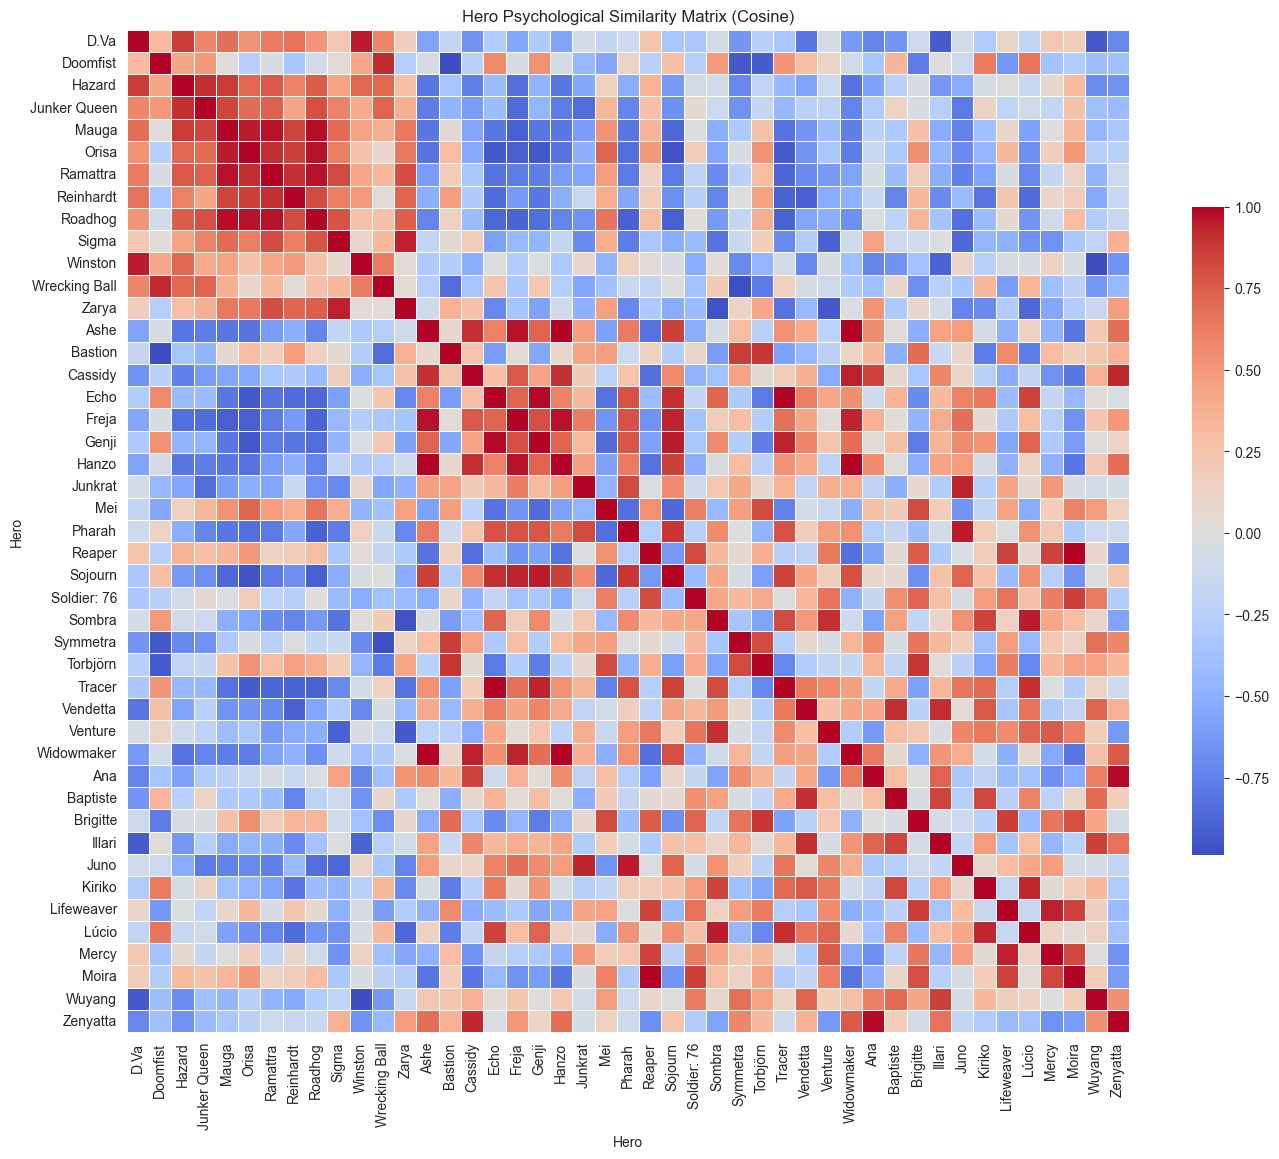

In [134]:

# Compute cosine similarity on scaled features
similarity_matrix = cosine_similarity(X_scaled)
sim_df = pd.DataFrame(similarity_matrix, index=df["Hero"], columns=df["Hero"])

plt.figure(figsize=(14, 12))
sns.heatmap(sim_df, cmap="coolwarm", center=0, square=True, linewidths=.5, cbar_kws={"shrink": 0.6})
plt.title("Hero Psychological Similarity Matrix (Cosine)")
plt.tight_layout()
plt.show()


### 4.1 Top-5 Similar Heroes for Each Hero

In [135]:

def top_k_similar(similarity_df, k=5):
    rows = []
    for hero in similarity_df.index:
        sims = similarity_df.loc[hero].drop(hero).sort_values(ascending=False).head(k)
        for other_hero, score in sims.items():
            rows.append({"Hero": hero, "Match": other_hero, "Cosine_Similarity": score})
    return pd.DataFrame(rows)

top5_df = top_k_similar(sim_df, k=5)
top5_df.head(10)


,Hero,Match,Cosine_Similarity
0,D.Va,Winston,0.951830
1,D.Va,Hazard,0.864457
2,D.Va,Mauga,0.681862
3,D.Va,Reinhardt,0.666640
4,D.Va,Ramattra,0.630849
5,Doomfist,Wrecking Ball,0.919745
6,Doomfist,Lúcio,0.656674
7,Doomfist,Kiriko,0.630574
8,Doomfist,Echo,0.571525
9,Doomfist,Genji,0.536260


In [136]:

# Save full top-5 similarity table
top5_df.to_csv("overwatch_full_similarity_top5.csv", index=False)
print("Saved: overwatch_full_similarity_top5.csv")

# Show some examples
for h in ["Hazard", "Mercy", "Genji", "Ana"]:
    if h in sim_df.index:
        print(f"\nTop 5 matches for {h}:")
        print(sim_df[h].sort_values(ascending=False).iloc[1:6])


Saved: overwatch_full_similarity_top5.csv

Top 5 matches for Hazard:
Hero
Junker Queen    0.908298
Mauga           0.869988
D.Va            0.864457
Ramattra        0.770520
Roadhog         0.757801
Name: Hazard, dtype: float64

Top 5 matches for Mercy:
Hero
Lifeweaver    0.939653
Reaper        0.852371
Moira         0.833203
Venture       0.762889
Brigitte      0.652035
Name: Mercy, dtype: float64

Top 5 matches for Genji:
Hero
Echo       0.979250
Sojourn    0.948640
Tracer     0.933548
Freja      0.804519
Pharah     0.778220
Name: Genji, dtype: float64

Top 5 matches for Ana:
Hero
Zenyatta      0.981729
Cassidy       0.848566
Illari        0.735784
Widowmaker    0.647921
Wuyang        0.617555
Name: Ana, dtype: float64


## 5. PCA: Hero Psychology Space

In [137]:

pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

df["PC1"] = pcs[:, 0]
df["PC2"] = pcs[:, 1]

print("Explained variance:", pca.explained_variance_ratio_)


Explained variance: [0.47571788 0.23649675]


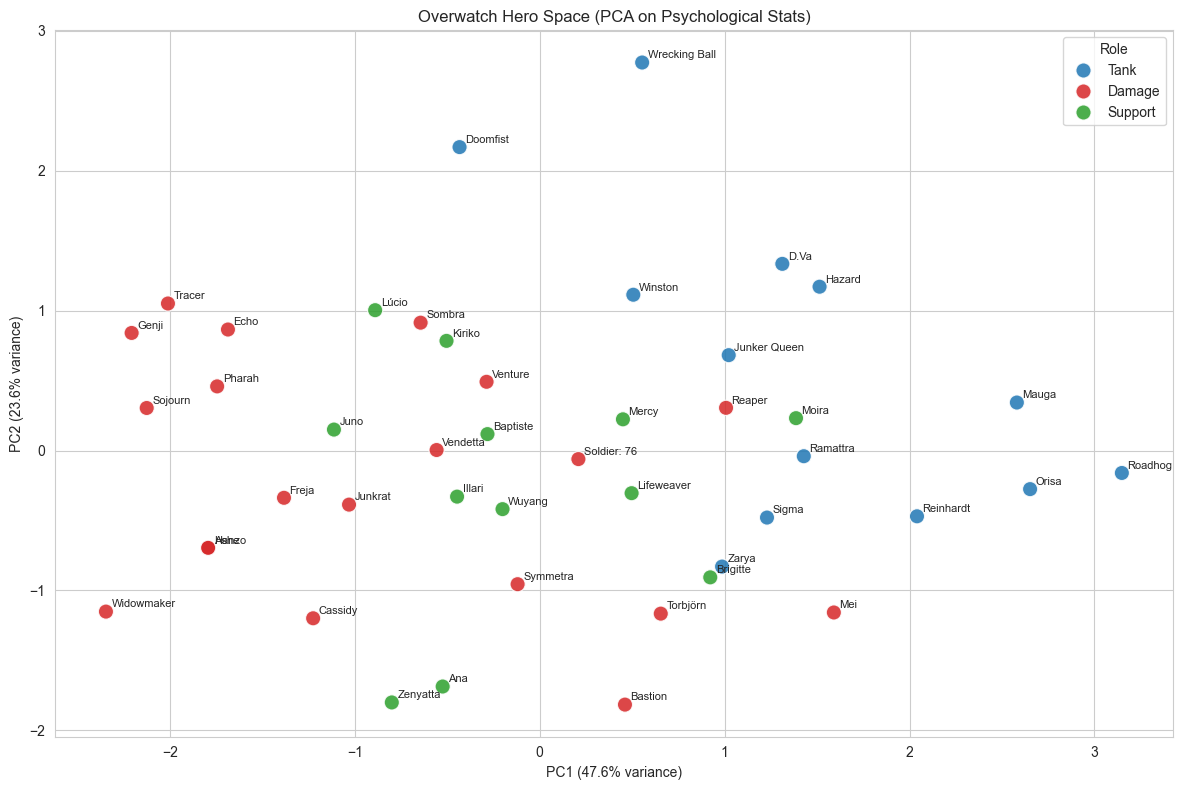

In [138]:

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x="PC1", y="PC2", hue="Role", palette=role_colors, s=120, alpha=0.85)

for i, row in df.iterrows():
    plt.annotate(row["Hero"], (row["PC1"] + 0.03, row["PC2"] + 0.03), fontsize=8)

plt.title("Overwatch Hero Space (PCA on Psychological Stats)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.tight_layout()
plt.show()


## 6. K-Means Clustering & Silhouette Analysis

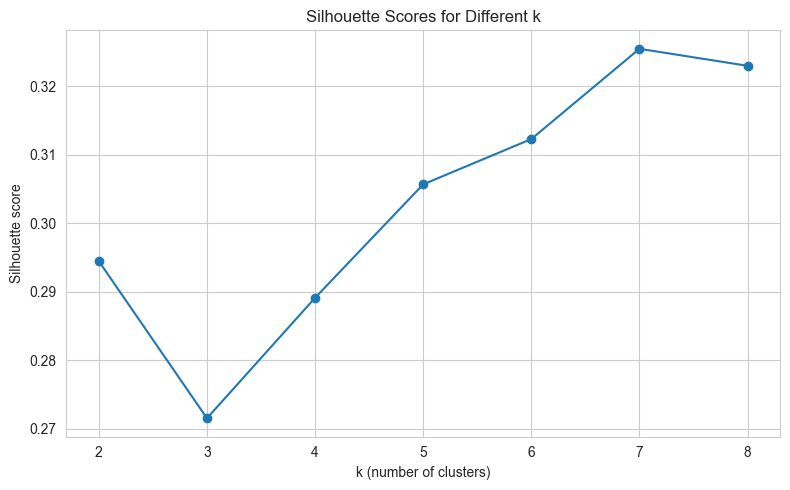

In [139]:

ks = list(range(2, 9))
sil_scores = []

for k in ks:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.figure(figsize=(8, 5))
plt.plot(ks, sil_scores, marker="o")
plt.xticks(ks)
plt.xlabel("k (number of clusters)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Scores for Different k")
plt.tight_layout()
plt.show()


In [140]:

# Final model with k = 4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_scaled)

df[["Hero", "Role", "Cluster"]].head()


,Hero,Role,Cluster
0,D.Va,Tank,2
1,Doomfist,Tank,0
2,Hazard,Tank,2
3,Junker Queen,Tank,2
4,Mauga,Tank,2


### 6.1 PCA Hero Space Colored by Cluster

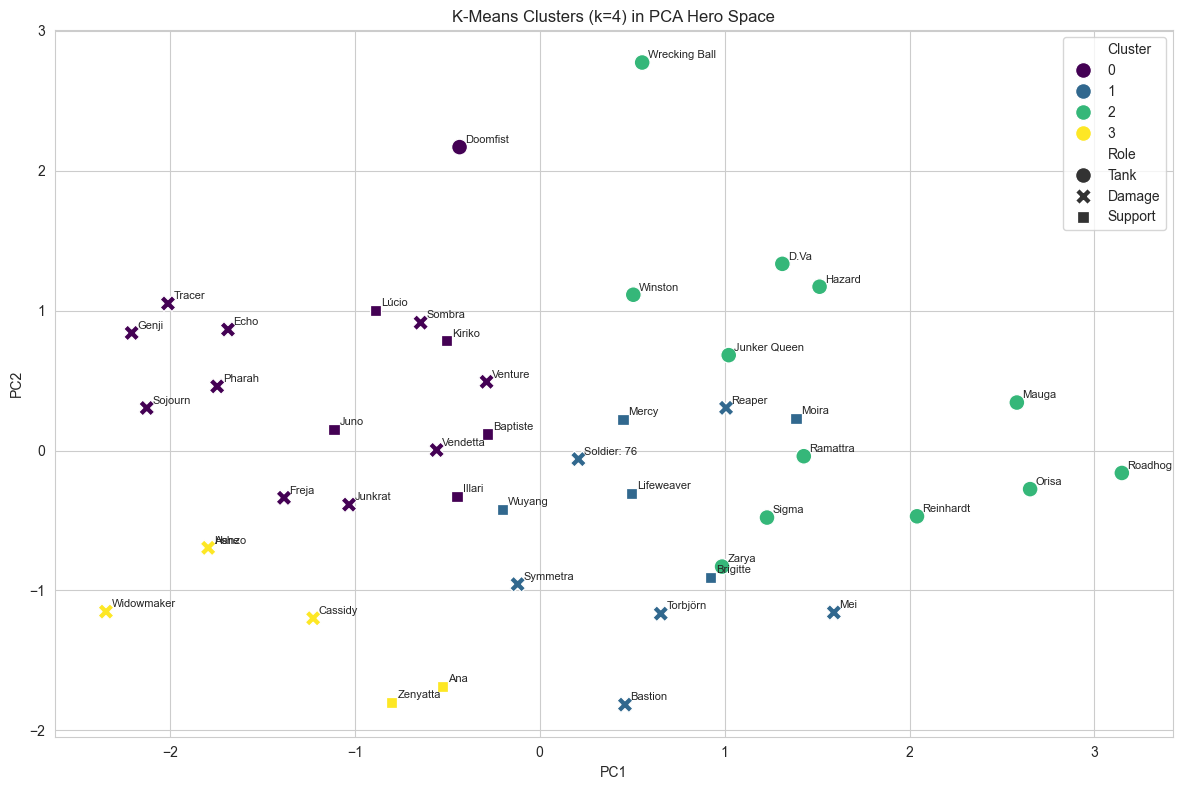

In [141]:

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x="PC1", y="PC2", hue="Cluster", style="Role", s=130, palette="viridis")

for i, row in df.iterrows():
    plt.annotate(row["Hero"], (row["PC1"] + 0.03, row["PC2"] + 0.03), fontsize=8)

plt.title("K-Means Clusters (k=4) in PCA Hero Space")
plt.tight_layout()
plt.show()


## 7. Role Composition by Cluster

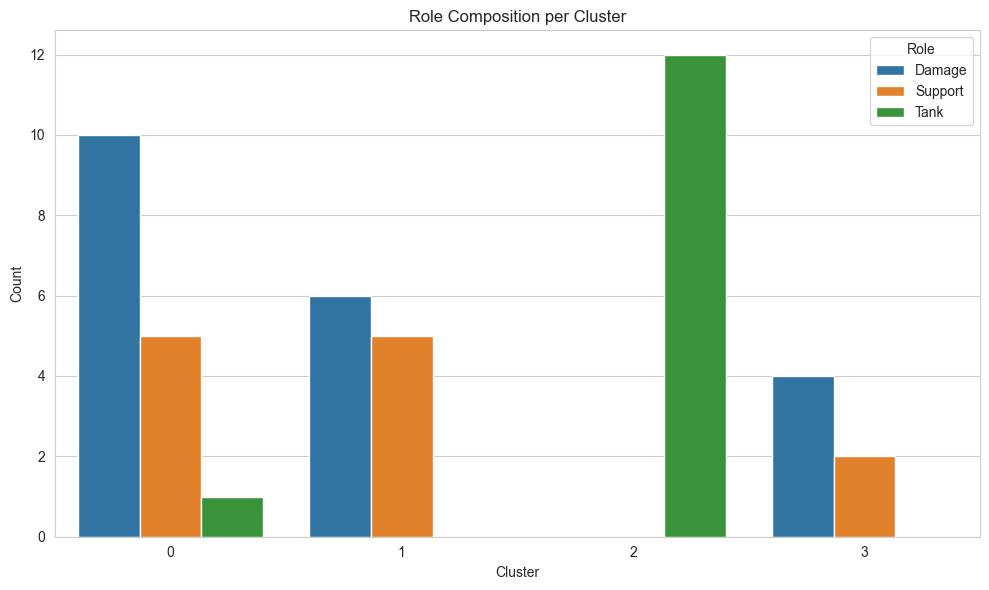

,Cluster,Role,Count
0,0,Damage,10
1,0,Support,5
2,0,Tank,1
3,1,Damage,6
4,1,Support,5
5,2,Tank,12
6,3,Damage,4
7,3,Support,2


In [142]:

role_counts = df.groupby(["Cluster", "Role"]).size().reset_index(name="Count")

plt.figure(figsize=(10, 6))
sns.barplot(data=role_counts, x="Cluster", y="Count", hue="Role")
plt.title("Role Composition per Cluster")
plt.tight_layout()
plt.show()

role_counts


## 8. Cluster Profiles: Average Stats per Archetype

In [143]:

cluster_means = df.groupby("Cluster")[features].mean()
cluster_means


,Mobility,Self_Sustain,Mechanical_Skill,HP
Cluster,,,,
0,7.937500,4.625000,7.875000,262.500000
1,4.909091,6.636364,4.636364,270.454545
2,4.916667,7.416667,6.083333,656.250000
3,3.166667,2.833333,9.166667,245.833333


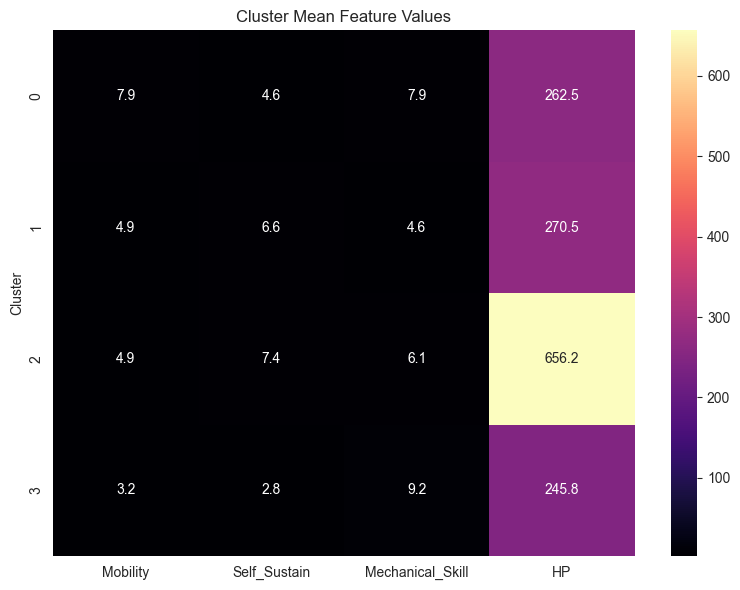

In [144]:

plt.figure(figsize=(8, 6))
sns.heatmap(cluster_means, annot=True, fmt=".1f", cmap="magma")
plt.title("Cluster Mean Feature Values")
plt.tight_layout()
plt.show()


## 9. Normalized Radar Charts for the Four Archetypes

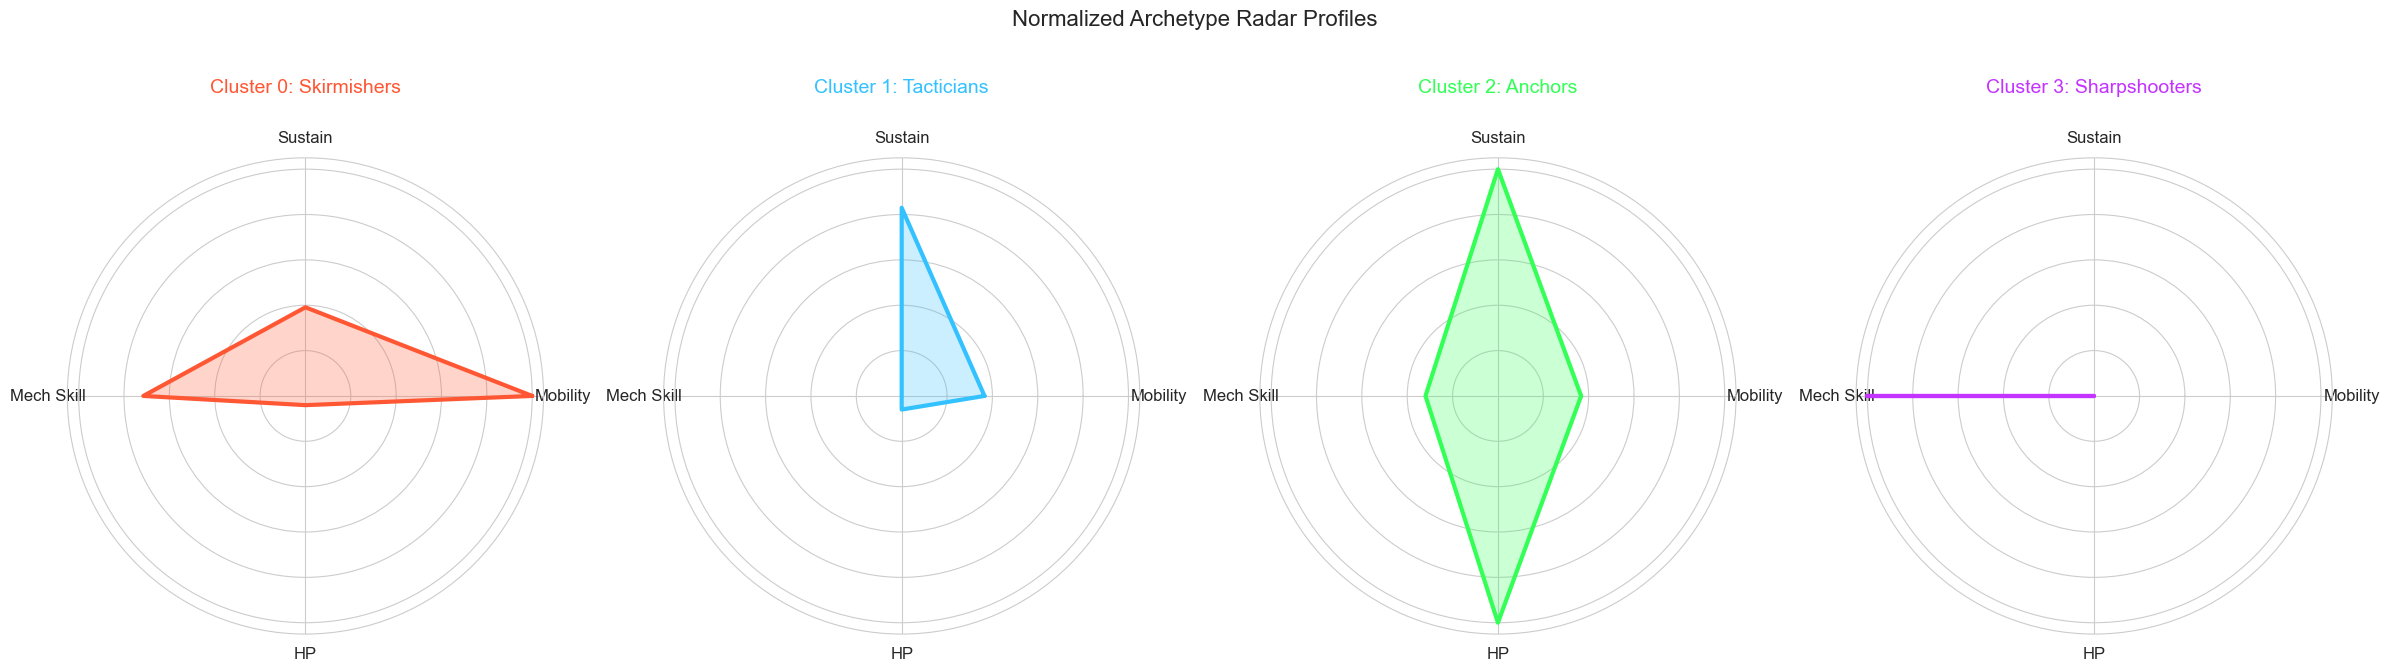

In [145]:

# Min-max normalize cluster means for radar visualization
radar_features = features.copy()
scaler_radar = MinMaxScaler()
radar_scaled = scaler_radar.fit_transform(cluster_means[radar_features])
radar_df = pd.DataFrame(radar_scaled, columns=radar_features)
radar_df["Cluster"] = cluster_means.index

# Archetype names & colors (based on earlier interpretation)
archetype_names = {
    0: "Skirmishers",
    1: "Tacticians",
    2: "Anchors",
    3: "Sharpshooters"
}

archetype_colors = {
    0: "#FF5733",
    1: "#33C1FF",
    2: "#33FF57",
    3: "#C433FF"
}

# Radar setup
N = len(radar_features)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, axes = plt.subplots(1, 4, subplot_kw=dict(polar=True), figsize=(24, 6))

for i, c in enumerate(sorted(radar_df["Cluster"].unique())):
    ax = axes[i]
    row = radar_df[radar_df["Cluster"] == c][radar_features].iloc[0]
    vals = row.values.tolist()
    vals += vals[:1]

    ax.plot(angles, vals, linewidth=3, linestyle="solid", color=archetype_colors[c])
    ax.fill(angles, vals, color=archetype_colors[c], alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(["Mobility", "Sustain", "Mech Skill", "HP"], fontsize=12)

    ax.set_yticklabels([])
    ax.set_ylim(0, 1.05)
    ax.set_title(f"Cluster {c}: {archetype_names[c]}", color=archetype_colors[c], fontsize=14, y=1.12)

plt.suptitle("Normalized Archetype Radar Profiles", fontsize=16, y=1.08)
plt.tight_layout()
plt.show()


## 10. Parallel Coordinates: How Archetypes Differ Across Stats

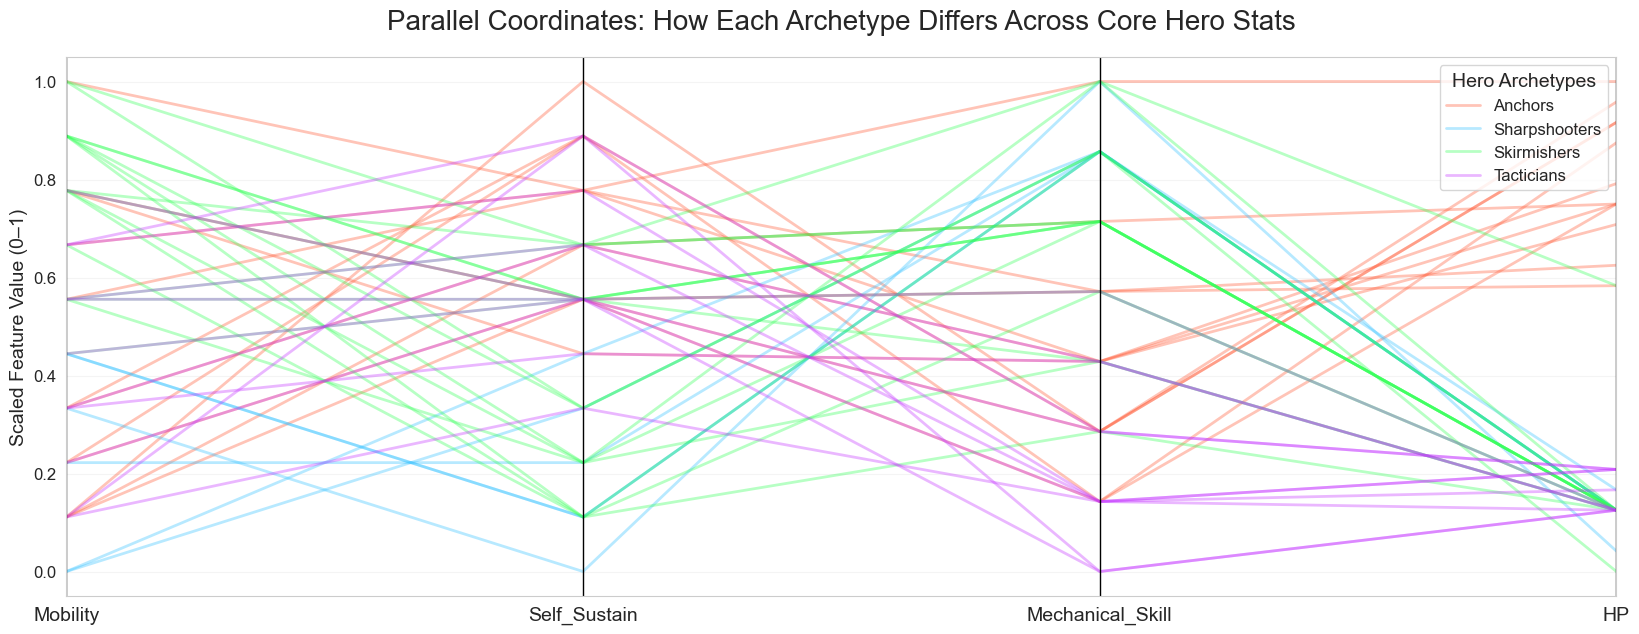

In [146]:
# Parallel Coordinates Plot with Archetype Labels & Matching Colors 

from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import parallel_coordinates

# Map clusters → archetype names
df["Archetype"] = df["Cluster"].map(archetype_names)

# Scale features
scaled = df.copy()
scaler_parallel = MinMaxScaler()
scaled[radar_features] = scaler_parallel.fit_transform(df[radar_features])

# Sort by archetype so the lines look grouped
scaled = scaled.sort_values("Archetype")

# Define color order matching archetype_names
color_order = [archetype_colors[i] for i in sorted(archetype_names.keys())]

plt.figure(figsize=(20, 7))

parallel_coordinates(
    scaled[['Archetype'] + radar_features],
    class_column='Archetype',
    color=color_order,
    linewidth=2,
    alpha=0.35
)

plt.title("Parallel Coordinates: How Each Archetype Differs Across Core Hero Stats", fontsize=20, pad=20)
plt.ylabel("Scaled Feature Value (0–1)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.grid(alpha=0.2)

# Improve legend
plt.legend(
    title="Hero Archetypes",
    title_fontsize=14,
    fontsize=12,
    frameon=True,
    loc="upper right"
)

plt.show()


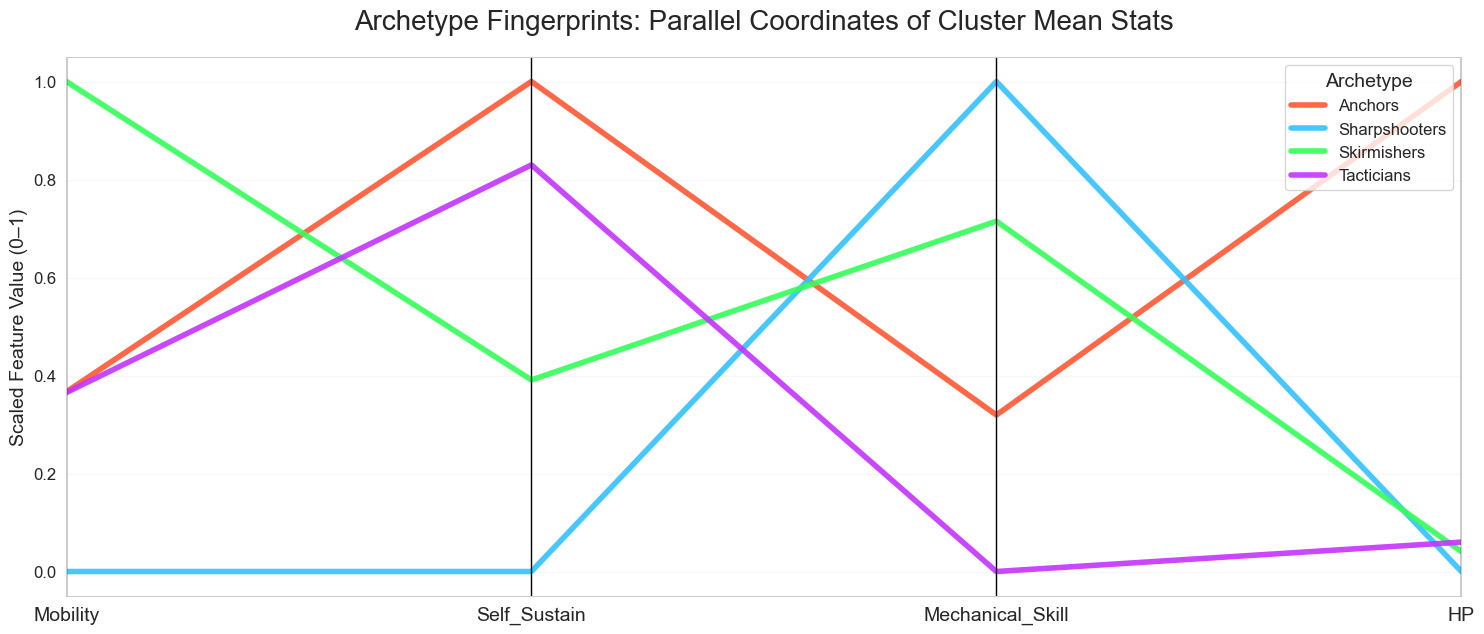

In [ ]:
# Cluster-Means Parallel Coordinates Plot (Clean Version)
from sklearn.preprocessing import MinMaxScaler

# Compute cluster means (only the 4 radar stats)
cluster_means_norm = df.groupby("Cluster")[radar_features].mean()

# Scale these means 0–1 for parallel coordinate layout
scaler = MinMaxScaler()
cluster_means_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_means_norm),
    columns=radar_features,
    index=cluster_means_norm.index
)

# Add archetype names for labeling
cluster_means_scaled["Archetype"] = cluster_means_scaled.index.map(archetype_names)

# Convert to long DataFrame for plotting
plot_df = cluster_means_scaled.reset_index(drop=True)

# Sort by archetype name to keep color order consistent
plot_df = plot_df.sort_values("Archetype")

# Build ordered color list
color_order = [archetype_colors[i] for i in sorted(archetype_names.keys())]

plt.figure(figsize=(18, 7))

parallel_coordinates(
    plot_df[["Archetype"] + radar_features],
    class_column="Archetype",
    color=color_order,
    linewidth=4,
    alpha=0.9
)

plt.title("Archetype Fingerprints: Parallel Coordinates of Cluster Mean Stats", fontsize=20, pad=20)
plt.ylabel("Scaled Feature Value (0–1)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.grid(alpha=0.15)

plt.legend(
    title="Archetype",
    title_fontsize=14,
    fontsize=12,
    frameon=True,
    loc="upper right"
)

plt.show()


## 11. Hero → Role → Archetype Mapping Export

In [148]:

archetype_labels = {
    0: "Skirmishers",
    1: "Tacticians",
    2: "Anchors",
    3: "Sharpshooters"
}

hero_archetypes = df[["Hero", "Role", "Cluster"]].copy()
hero_archetypes["Archetype"] = hero_archetypes["Cluster"].map(archetype_labels)

hero_archetypes.to_csv("overwatch_hero_archetypes.csv", index=False)
print("Saved: overwatch_hero_archetypes.csv")
hero_archetypes.sort_values(["Archetype", "Hero"]).head(15)


Saved: overwatch_hero_archetypes.csv


,Hero,Role,Cluster,Archetype
0,D.Va,Tank,2,Anchors
2,Hazard,Tank,2,Anchors
3,Junker Queen,Tank,2,Anchors
4,Mauga,Tank,2,Anchors
5,Orisa,Tank,2,Anchors
6,Ramattra,Tank,2,Anchors
7,Reinhardt,Tank,2,Anchors
8,Roadhog,Tank,2,Anchors
9,Sigma,Tank,2,Anchors
10,Winston,Tank,2,Anchors


## 12. Archetype Examples & Player Guidance Helper

In [149]:

def show_archetype_examples(df, archetype_labels, max_heroes=6):
    for c in sorted(archetype_labels.keys()):
        label = archetype_labels[c]
        subset = df[df["Cluster"] == c]
        heroes = subset["Hero"].tolist()
        print(f"\nArchetype {c} — {label}")
        print("  Examples:", ", ".join(heroes[:max_heroes]))

show_archetype_examples(df, archetype_labels)



Archetype 0 — Skirmishers
  Examples: Doomfist, Echo, Freja, Genji, Junkrat, Pharah

Archetype 1 — Tacticians
  Examples: Bastion, Mei, Reaper, Soldier: 76, Symmetra, Torbjörn

Archetype 2 — Anchors
  Examples: D.Va, Hazard, Junker Queen, Mauga, Orisa, Ramattra

Archetype 3 — Sharpshooters
  Examples: Ashe, Cassidy, Hanzo, Widowmaker, Ana, Zenyatta


## 13. Case Study: Freja and Her Closest Psychological Neighbors

In [150]:

target = "Freja"
if target in sim_df.index:
    print(f"Top 5 psychological matches for {target}:")
    print(sim_df[target].sort_values(ascending=False).iloc[1:6])
else:
    print("Freja not found in similarity matrix index.")


Top 5 psychological matches for Freja:
Hero
Ashe          0.964227
Hanzo         0.964227
Widowmaker    0.934841
Sojourn       0.931288
Genji         0.804519
Name: Freja, dtype: float64



## 14. Final Summary

• We extended the original *"We Are Who We Lock"* cosine-similarity analysis to the
  full 45-hero Overwatch roster, using a richer feature set:
  **Mobility**, **Self-Sustain**, **Mechanical Skill**, and **HP**.

• Using **PCA**, we built a 2D “hero psychology space” that shows how heroes naturally
  separate into patterns based on how they approach fights, take information in, and
  act on it.

• Using **K-Means** with silhouette support (optimal k = 4), we discovered four
  psychologically meaningful archetypes:

### **Archetype 0 — Skirmishers**
Fast, evasive, high-mechanics heroes.
They thrive on constant movement, proactive decision-making, and high APM.

### **Archetype 1 — Tacticians**
Moderate mobility + moderate sustain.
They win through positioning, timing, cooldown management, and game sense.

### **Archetype 2 — Anchors**
High-HP, high-sustain heroes.
They stabilize space, protect teammates, and simplify the fight around them.

### **Archetype 3 — Sharpshooters**
Low-sustain, high-precision heroes.
They rely on accuracy, prediction, and tight mechanical discipline.

• These archetypes line up with how players intuitively describe themselves:
  **creative skirmishers**, **strategic tacticians**, **protective anchors**, and  
  **precise sharpshooters** — supporting the claim that *we really are who we lock.*

**Saved Artifacts**
- `overwatch_full_similarity_top5.csv` — top-5 similarity matches for every hero.  
- `overwatch_hero_archetypes.csv` — final hero → role → archetype mapping.

---

### How to Use This as a Player

- If you enjoy **fast, risky outplays**, try heroes from the **Skirmishers**.
- If you like **protecting your team and controlling space**, explore the **Anchors**.
- If you think in terms of **angles, cooldowns, and smart positioning**, check **Tacticians**.
- If you love **aim duels and precision**, start with the **Sharpshooters**.

Your current hero pool probably clusters in one or two archetypes —  
and that cluster reflects *your natural information-processing style*.

Understanding your archetype helps you:
1. Find new heroes you’ll naturally enjoy,  
2. Understand why some heroes feel stressful or unnatural,  
3. Improve faster by playing in a way that matches how your brain prefers to play.

This analysis suggests that hero choice isn’t random —  
**it’s a reflection of how you interpret the game, solve problems, and make decisions.**
